## Build a non-parametric model for single and binary stars using Gaia data.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from astropy.table import Table
from astropy.io import fits
from scipy import spatial
from sklearn import neighbors as neighbours

import sys
sys.path.insert(0, "../")

import velociraptor

%matplotlib inline

np.random.seed(42)

In [2]:
# Load in the data and save it again, just so we calculate additional properties that we need:
def _calculate_source_properties(path, **kwargs):
    sources = Table.read(path, **kwargs)

    for band in ("g", "bp", "rp"):
        sources["absolute_{}_mag".format(band)] = \
              sources["phot_{}_mean_mag".format(band)] \
            + 5 * np.log10(sources["parallax"]/100.0)

    sources["rv_single_epoch_variance"] = sources["radial_velocity_error"]**2 \
                                        * sources["rv_nb_transits"] * np.pi/2.0

    # Approximate temperature from bp-rp colour
    use_in_fit = np.isfinite(sources["radial_velocity"]) \
               * (sources["phot_bp_rp_excess_factor"] < 1.5) \
               * np.isfinite(sources["bp_rp"]) \
               * np.isfinite(sources["teff_val"]) \
               * (sources["bp_rp"] < 2.5) \
               * (sources["bp_rp"] > 0.5)

    x = sources["bp_rp"][use_in_fit]
    y = sources["teff_val"][use_in_fit]

    coeff = np.polyfit(1.0/x, y, 2)

    sources["approx_teff_from_bp_rp"] = np.clip(
        np.polyval(coeff, 1.0/sources["bp_rp"]),
        3500, 8000)
    sources["rv_abs_diff_template_teff"] = np.abs(sources["approx_teff_from_bp_rp"] - sources["rv_template_teff"])
    
    # Astrometric unit weight error
    sources["astrometric_unit_weight_error"] = np.sqrt(
        sources["astrometric_chi2_al"]/(sources["astrometric_n_obs_al"] - 5))
    
    # Photometric variability
    sources["phot_rp_variability"] = np.sqrt(sources["astrometric_n_good_obs_al"]) \
                                   * sources["phot_rp_mean_flux"] \
                                   / sources["phot_rp_mean_flux_error"]
    
    sources.write(path, overwrite=True)
    del sources
    return None

data_path = "../data/rv-all-subset-1e4.fits"
_calculate_source_properties(data_path)

/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


In [3]:
# Load in the data table again, but this time use fits for efficiency
hdu = fits.open(data_path)[1]
data = hdu.data

(10.13891877241954, -13.33792607352664)

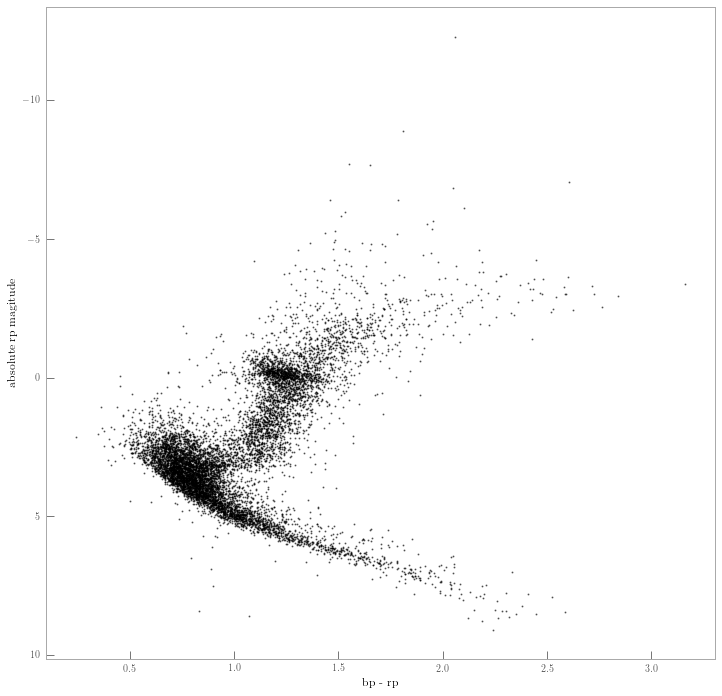

In [4]:
# Plot the CMD
scatter_kwds = dict(s=1, alpha=0.5, c="#000000", cmap="viridis")
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.scatter(data["bp_rp"], data["absolute_rp_mag"],
           **scatter_kwds)
ax.set_xlabel(r"\textrm{bp - rp}")
ax.set_ylabel(r"\textrm{absolute rp magitude}")
ax.set_ylim(ax.get_ylim()[::-1])

In [5]:
# what labels are we going to build the KD-tree in?
kdt_label_names = ("bp_rp", "absolute_rp_mag")

predictor_label_names = (
    "rv_single_epoch_variance",
    "rv_abs_diff_template_teff",
    "astrometric_unit_weight_error",
    "phot_bp_rp_excess_factor",
    "phot_rp_variability"
)

label_names_to_show_in_log = ()

latex_label_names = dict(
    bp_rp=r"\textrm{bp - rp}",
    absolute_rp_mag=r"\textrm{absolute rp mag}",
    rv_single_epoch_variance=r"\textrm{rv single epoch variance}",
    rv_abs_diff_template_teff=r"\textrm{rv abs diff template teff}",
    astrometric_unit_weight_error=r"\textrm{astrometric unit weight error}",
    phot_bp_rp_excess_factor=r"\textrm{phot bp rp excess factor}",
    phot_rp_variability=r"\textrm{phot rp variability}"
)

X = np.vstack([data[ln] for ln in kdt_label_names]).T
# TODO: Right now I am *requiring* that all predictor labels and KD-Tree
#       labels are finite, but we may want to change this in the future.
all_label_names = tuple(list(kdt_label_names) + list(predictor_label_names))
subset = np.all(np.isfinite(np.vstack([data[ln] for ln in all_label_names])), axis=0)
X = X[subset]
X_scale = np.ptp(X, axis=0)
X_mean = np.mean(X, axis=0)

_scale = lambda a: (a - X_mean)/X_scale
_descale = lambda a: a * X_scale + X_mean

# Normalise the array for the KD-tree
X_norm = _scale(X)

In [6]:
kdt_kwds = dict(leaf_size=40, metric="minkowski")
kdt = neighbours.KDTree(X_norm, **kdt_kwds)

In [7]:
K = 30 # nearest neighbours
index = np.random.choice(len(X), 1)[0]
dist, k_indices = kdt.query(X_norm[[index]], K)

# Do a radius query
k_indices, dist = kdt.query_radius(X_norm[[index]], 0.05, return_distance=True)
k_indices, dist = (k_indices[0], dist[0])

(0.6054710743632368, 2.926078025398784)

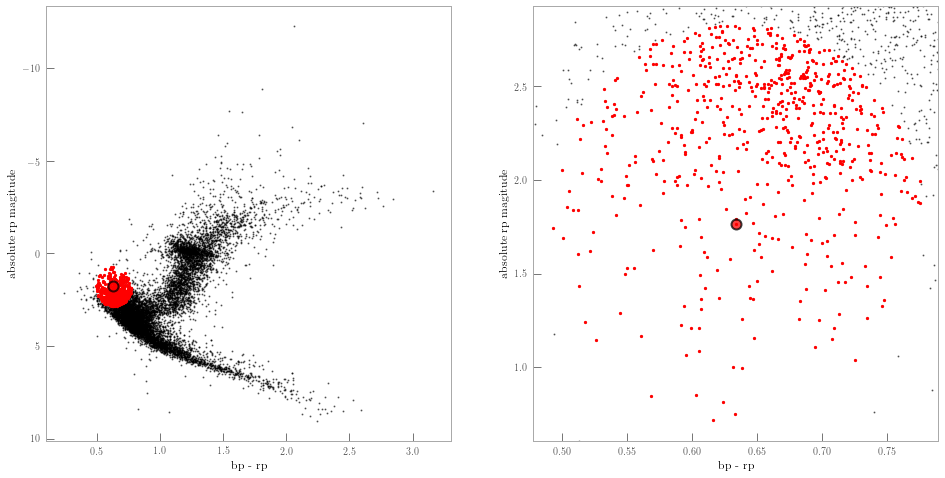

In [8]:
# Plot the CMD
scatter_kwds = dict(s=1, alpha=0.5, c="#000000", cmap="viridis")
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
for ax in axes:
    ax.scatter(data["bp_rp"], data["absolute_rp_mag"],
               **scatter_kwds)
    ax.set_xlabel(r"\textrm{bp - rp}")
    ax.set_ylabel(r"\textrm{absolute rp magitude}")
    ax.set_ylim(ax.get_ylim()[::-1])

    ax.scatter([X[index, 0]], [X[index, 1]],
               c="r", edgecolor="k", s=100, zorder=10, alpha=0.75,
               linewidth=2)

    ax.scatter(X[k_indices, 0], X[k_indices, 1],
               c="r", s=5, zorder=5)

# Enhance.
ax = axes[1]
xp, yp = X[index]
xs, ys = (0.1, 0.1)
xs, ys = 1.10 * np.max(np.abs(X[k_indices] - X[index]), axis=0)
ax.set_xlim(xp - xs, xp + xs)
ax.set_ylim(yp - ys, yp + ys)

What I really want is a ball around some point, but require that the ball have some characteristics (e.g., minimum range in absolute rp magnitude, minimum range in colour, minimum number of points). For now I will just require the nearest 100 points, and we can make this function more complicated later on.

In [9]:
def get_ball_around_point(index, K=1000, full_output=False):
    dist, k_indices = kdt.query(X_norm[[index]], K)
    dist, k_indices = (dist[0], k_indices[0])
    return (k_indices, dist) if full_output else k_indices

In [10]:
# Plot the CMD
def plot_hrd_and_ball_around_point(X, index, k_indices, latex_label_names=None,
                                   zoom_factor=1.5, figsize=(16, 8), **kwargs):
    
    scatter_kwds = dict(s=1, alpha=0.5, c="#000000", cmap="viridis")
    scatter_kwds.update(kwargs)
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    for ax in axes:
        ax.scatter(X.T[0], X.T[1], **scatter_kwds)
        
        # TODO: don't assume this?
        ax.set_ylim(ax.get_ylim()[::-1])

        ax.set_xlabel(latex_label_names.get(kdt_label_names[0], None))
        ax.set_ylabel(latex_label_names.get(kdt_label_names[1], None))

        ax.scatter([X[index, 0]], [X[index, 1]],
                   c="r", edgecolor="k", s=100, zorder=10, alpha=0.75,
                   linewidth=2)

        ax.scatter(X[k_indices, 0], X[k_indices, 1],
                   c="r", s=5, zorder=5)

    # Enhance.
    ax = axes[1]
    xp, yp = X[index]
    xs, ys = zoom_factor * np.max(np.abs(X[k_indices] - X[index]), axis=0)
    ax.set_xlim(xp - xs, xp + xs)
    ax.set_ylim(yp - ys, yp + ys)
    
    return fig


(0, 2.5)

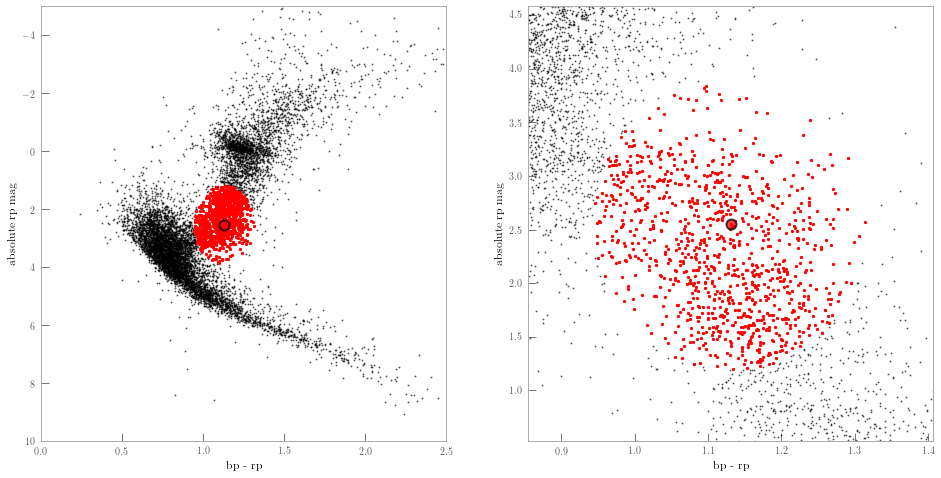

In [95]:
index = np.random.choice(len(X), 1)[0]
k_indices = get_ball_around_point(index)
fig = plot_hrd_and_ball_around_point(X, index, k_indices,
                                     latex_label_names=latex_label_names)
fig.axes[0].set_ylim(10, -5)
fig.axes[0].set_xlim(0, 2.5)

For that random point and that ball  of points, show the distributions of the things that we want to model.

In [78]:
def plot_predictor_label_properties(index, k_indices, N_bins=30, **kwargs):
    L = len(predictor_label_names)
    print(predictor_label_names)
    fig, axes = plt.subplots(2, 3, figsize=(6 * 3, 6 * 2))
    axes = np.array(axes).flatten()
    for i, (ax, label_name) in enumerate(zip(axes, predictor_label_names)):

        values = data[label_name][subset][k_indices]
        finite_values = values[np.isfinite(values)]

        is_semilogx = label_name in label_names_to_show_in_log

        if is_semilogx:
            bins = np.logspace(np.log10(finite_values.min()), np.log10(finite_values.max()), N_bins)
            ax.set_xscale("log")

        else:
            bins = np.linspace(finite_values.min(), finite_values.max(), N_bins)

        kwds = dict(facecolor="#CCCCCC", bins=bins)
        kwds.update(kwargs)
        ax.hist(finite_values, **kwds)
        ax.axvline(data[label_name][subset][index], 
                   c="#000000", lw=1, linestyle="--", zorder=100)
        ax.set_xlabel(latex_label_names.get(label_name, None))
    
    for ax in axes[L:]:
        ax.set_visible(False)
    
    return fig

('rv_single_epoch_variance', 'rv_abs_diff_template_teff', 'astrometric_unit_weight_error', 'phot_bp_rp_excess_factor', 'phot_rp_variability')


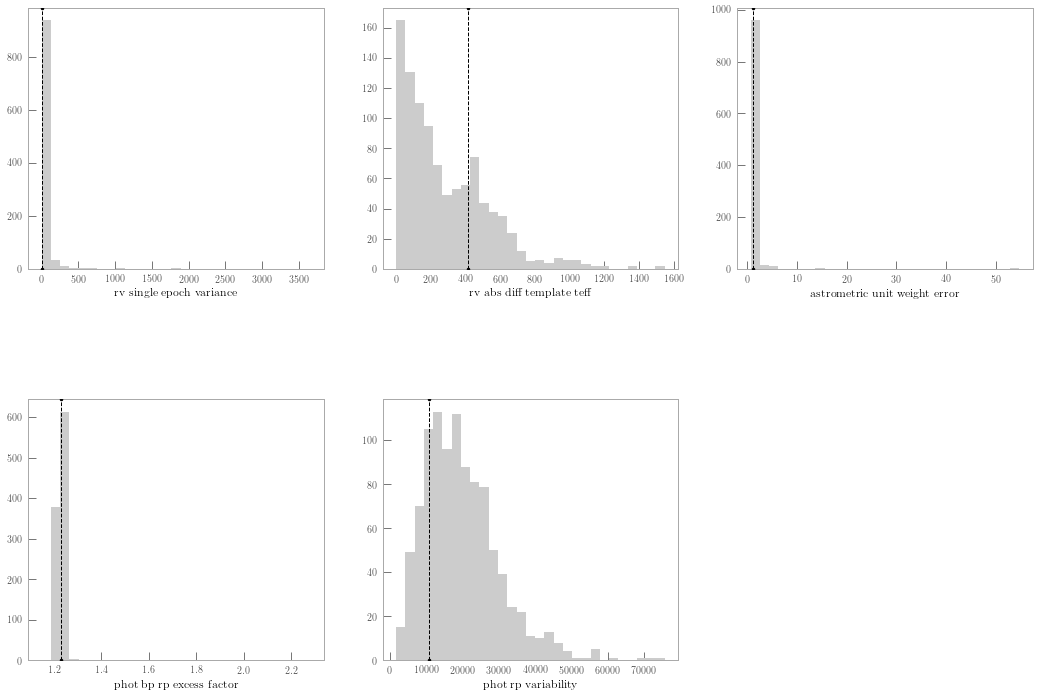

In [79]:
fig = plot_predictor_label_properties(index, k_indices)

In [14]:
# Just plot a normal and log-normal to look at what we are dealing with.
from scipy import stats

def plot_two_component_model(x, norm_mu, norm_sigma, lognorm_mu, lognorm_sigma, 
                             theta=0.5, figsize=(8, 8)):
    
    """
    pdf_norm = theta * stats.norm.pdf(x, loc=norm_loc, scale=norm_scale)
    pdf_lognorm = (1 - theta) * stats.lognorm.pdf(x - lognorm_loc, s=lognorm_scale, loc=0, scale=1)
    #dist  = stats.lognorm([lognorm_scale],loc=lognorm_loc)
    #pdf_lognorm = dist.pdf(x)
    
    pdf_sum = pdf_norm + pdf_lognorm
    """
    
    pdf_lognorm = (1.0 - theta)/(x * lognorm_sigma * np.sqrt(2*np.pi)) \
                * np.exp(-0.5 * ((np.log(x) - lognorm_mu)/lognorm_sigma)**2)
    pdf_norm = theta * (2 * np.pi * norm_sigma**2)**(-0.5) * np.exp(-(x - norm_mu)**2/(2*norm_sigma**2))
    
    pdf_sum = pdf_lognorm * pdf_norm
    
    scale_norm = 1.0/(np.nansum(pdf_norm)/np.nansum(pdf_sum))
    scale_lognorm = 1.0/(np.nansum(pdf_lognorm)/np.nansum(pdf_sum))
    
    
    kwds = dict(linestyle="-", marker="None")
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    _ = ax.plot(x, scale_norm * pdf_norm, c="r", **kwds)
    __ = ax.plot(x, scale_lognorm * pdf_lognorm, c="b", **kwds)
    ax.plot(x, pdf_sum, c="k", **kwds)
    #legend = fig.legend([_, __], labels=("Single stars", "Stellar multiples"))
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"\textrm{pdf}")
    
    fig.tight_layout()
    return fig


/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()


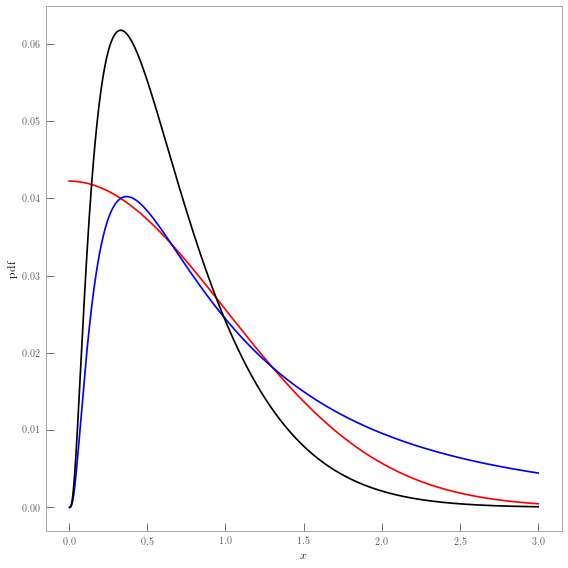

In [15]:
x = np.linspace(0, 3, 1000)
fig = plot_two_component_model(x, norm_mu=0, norm_sigma=1, 
                               lognorm_mu=0, lognorm_sigma=1)

In [16]:
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

#w = widgets.IntSlider()
#display(w)

x = np.linspace(0, 100, 1000)


def norm_pdf(x, norm_mu, norm_sigma, theta):
    return theta * (2 * np.pi * norm_sigma**2)**(-0.5) * np.exp(-(x - norm_mu)**2/(2*norm_sigma**2))
    
def lognorm_pdf(x, lognorm_mu, lognorm_sigma, theta):
    return (1.0 - theta)/(x * lognorm_sigma * np.sqrt(2*np.pi)) \
           * np.exp(-0.5 * ((np.log(x) - lognorm_mu)/lognorm_sigma)**2)

kwds = dict(linestyle="-", marker="None")


/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


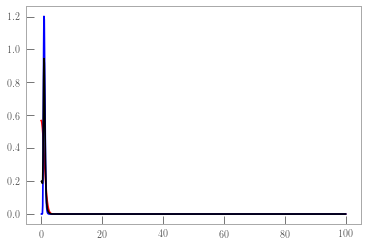

In [17]:
@interact(norm_mu=(0.0,20.0,0.1), norm_sigma=(0.0, 20,0.1),
          lognorm_mu=(0, 20.0, 0.1), lognorm_sigma=(0, 20, 0.1),
          theta=(0, 1, 0.01))
def h(norm_mu=0, norm_sigma=1, lognorm_mu=0, lognorm_sigma=0.25,theta=0.5):
    y_norm = norm_pdf(x, norm_mu, norm_sigma, theta)
    y_lognorm = lognorm_pdf(x, lognorm_mu, lognorm_sigma, theta)
    y_sum = y_norm + y_lognorm
    
    scale_norm = 1.0/(np.nansum(y_norm)/np.nansum(y_sum))
    scale_lognorm = 1.0/(np.nansum(y_lognorm)/np.nansum(y_sum))
    #scale_norm = np.nansum(y_sum)
    #scale_lognorm = np.nansum(y_sum)
    plt.plot(x, scale_norm * y_norm, c="r", **kwds)[0]
    plt.plot(x, scale_lognorm * y_lognorm, c="b", **kwds)[0]
    plt.plot(x, y_sum, c="k", **kwds)
    plt.show()
    return None

In [18]:
# Fit it in python.
y = data[subset]["rv_single_epoch_variance"][k_indices]

def norm_pdf(x, norm_mu, norm_sigma, theta):
    return theta * (2 * np.pi * norm_sigma**2)**(-0.5) * np.exp(-(x - norm_mu)**2/(2*norm_sigma**2))
    
def lognorm_pdf(x, lognorm_mu, lognorm_sigma, theta):
    return (1.0 - theta)/(x * lognorm_sigma * np.sqrt(2*np.pi)) \
           * np.exp(-0.5 * ((np.log(x) - lognorm_mu)/lognorm_sigma)**2)


def ln_likelihood(y, theta, s_mu, s_sigma, b_mu, b_sigma):
    
    s_ivar = s_sigma**-2
    b_ivar = b_sigma**-2
    hl2p = 0.5 * np.log(2*np.pi)
    
    s_lpdf = np.log(theta) - hl2p + 0.5 * np.log(s_ivar) \
           - 0.5 * (y - s_mu)**2 * s_ivar
    
    b_lpdf = np.log(1 - theta) - np.log(y*b_sigma) - hl2p \
           - 0.5 * (np.log(y) - b_mu)**2 * b_ivar
    ll = np.sum(s_lpdf) + np.sum(b_lpdf)
    #print(lpdf)
    
    assert np.isfinite(ll)
    print(ll)
    return ll

def ln_prior(theta, s_mu, s_sigma, b_mu, b_sigma):
    if theta > 1 or theta < 0 or s_mu < 0 or s_sigma < 0 or b_sigma < 0 \
    or s_sigma > 2 or s_mu > 1:
        return -np.inf
    return 0

def ln_prob(y, theta, s_mu, s_sigma, b_mu, b_sigma):
    lp = ln_prior(theta, s_mu, s_sigma, b_mu, b_sigma)
    if np.isfinite(lp):
        return lp + ln_likelihood(y, theta, s_mu, s_sigma, b_mu, b_sigma)
    return lp


def nlp(params):
    return -ln_prob(y, *params)

value = ln_prob(y, 0.5, 1, 1, 0, 0.25)

from scipy.optimize import minimize

p_opt = minimize(nlp, x0=[0.8, 1, 1, 0, 0.25])
print(p_opt)


-2139178.5680168504
-2139624.855119479
-2139624.8551753582
-2139624.7924008574
-2139624.854863752
-2139624.8514501774
-2139624.855119479


/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:87: RuntimeWarning: invalid value encountered in multiply
  return f(xk + s*pk, *args)


AssertionError: 

/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


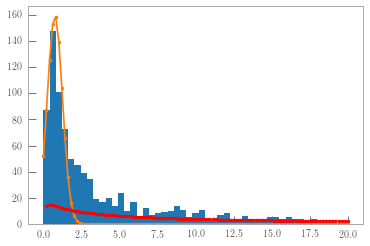

In [19]:
fig, ax = plt.subplots()
ax.hist(y, bins=np.linspace(0, 20))

def norm_pdf(x, norm_mu, norm_sigma, scale):
    return scale * (2 * np.pi * norm_sigma**2)**(-0.5) * np.exp(-(x - norm_mu)**2/(2*norm_sigma**2))

def lognorm_pdf(x, lognorm_mu, lognorm_sigma, scale):
    return scale/(x * lognorm_sigma * np.sqrt(2*np.pi)) \
           * np.exp(-0.5 * ((np.log(x) - lognorm_mu)/lognorm_sigma)**2)


x = np.linspace(0, 20, 100)
ax.plot(x, norm_pdf(x, 0.75, 0.5, 200))
ax.plot(x, lognorm_pdf(x, 3, 2, 200), c='r')


In [20]:
p = [0.5, 0.75, 0.5, 3, 2]
ln_prob(y, *p)

p_opt = minimize(nlp, x0=p)
print(p_opt)



-8440554.090370608
-8440554.090370608
-8440554.090370608
-8440554.089439465
-8440553.58760855
-8440554.090377789
-8440554.090366
-8440554.090370608
-931099.5376044635
-931099.5376044635
-931099.5376044635
-931099.5375023813
-931099.519360128
-931099.5376116436
-931099.5375998546
-931099.5376044635
-931099.5376044635
-931099.5376044635
-931099.5375023813
-931099.519360128
-931099.5376116436
-931099.5375998546
-931099.5376044635
-931099.5376044635
-931099.5376044635
-931099.5375023813
-931099.519360128
-931099.5376116436
-931099.5375998546
      fun: 931099.5376044635
 hess_inv: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  9.99997092e-01, -1.71110161e-03,
        -2.01126844e-09,  1.29457185e-09],
       [ 0.00000000e+00, -1.71110161e-03,  2.95893944e-06,
         9.64079914e-10,  1.43969263e-09],
       [ 0.00000000e+00, -2.01126844e-09,  9.64079914e-10,
         1.00000000e+00, -1.30917273e-10],
       [

In [21]:
p_opt.x

array([0.5       , 0.75187057, 1.50999827, 2.99998558, 2.00000926])

mode: 0.37


/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


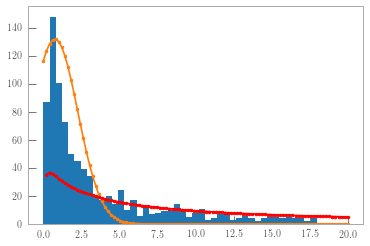

In [22]:
fig, ax = plt.subplots()
ax.hist(y, bins=np.linspace(0, 20))

x = np.linspace(0, 20, 100)
ax.plot(x, norm_pdf(x, p_opt.x[1], p_opt.x[2], len(y) * p_opt.x[0]))
ax.plot(x, lognorm_pdf(x, p_opt.x[3], p_opt.x[4], len(y) * p_opt.x[0]), c='r')
print("mode: {0:.2f}".format(np.exp(p_opt.x[3] - p_opt.x[4]**2)))

In [23]:
# Fit a two component model to those data.
# TODO: Do this in TensorFlow.

stan_model_code = """
    data {
        int<lower=1> N; // number of data points
        real y[N]; // the data points.
    }

    parameters {
        real<lower=0,upper=1> theta; // the mixing parameter
        real<lower=0,upper=5> mu_single; // single star distribution mean
        real<lower=0.25,upper=2> sigma_single; // single star distribution sigma
        real<lower=1.5> sigma_multiple; // multiplcity log-normal distribution sigma
        real<lower=log(mu_single)+pow(sigma_multiple,2)> mu_multiple; // multiplicity log-normal distribution mean
    }
    
    model {
        theta ~ beta(5, 5);
        for (n in 1:N)
            target += log_mix(theta,
                              normal_lpdf(y[n] | mu_single, sigma_single),
                              lognormal_lpdf(y[n] | mu_multiple, sigma_multiple));
  }
"""

model_path = "non-parametric-model.stan"
with open(model_path, "w") as fp:
    fp.write(stan_model_code)

import stan_utils as stan
model = stan.load_stan_model(model_path)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7f57cc0343b42a138a61145455be132a NOW.


In [24]:
N = len(y)
data_dict = dict(y=y, N=N)
init_dict = dict(theta=0.3, mu_single=p_opt.x[1], sigma_single=1,
                 mu_multiple=p_opt.x[3] + 1, sigma_multiple=p_opt.x[4])                                            


In [26]:
kwds = dict(
    data=data_dict,
    init=init_dict,
    iter=100000, 
    tol_obj=7./3 - 4./3 - 1, # machine precision
    tol_grad=7./3 - 4./3 - 1, # machine precision
    tol_rel_grad=1e3,
    tol_rel_obj=1e4
)
stan_opt = model.optimizing(**kwds)

/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:362: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(np.asarray(v).dtype, int):
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:364: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [27]:
print(stan_opt)

OrderedDict([('theta', array(0.18207534)), ('mu_single', array(0.53497278)), ('sigma_single', array(0.25)), ('sigma_multiple', array(1.5)), ('mu_multiple', array(1.62446059))])


In [28]:
samples = model.sampling(**stan.sampling_kwds(data=data_dict, init=init_dict, iter=2000))
chains = samples.extract()


/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:362: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(np.asarray(v).dtype, int):
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:364: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [29]:
label_names = [ea.replace("_", " ") for ea in tuple(chains.keys())[:-1]]

C = np.array([chains[k] for k in chains.keys() if k != "lp__"])
print(chains.keys())

odict_keys(['theta', 'mu_single', 'sigma_single', 'sigma_multiple', 'mu_multiple', 'lp__'])


['theta', 'mu single', 'sigma single', 'sigma multiple', 'mu multiple']
(5, 4000)


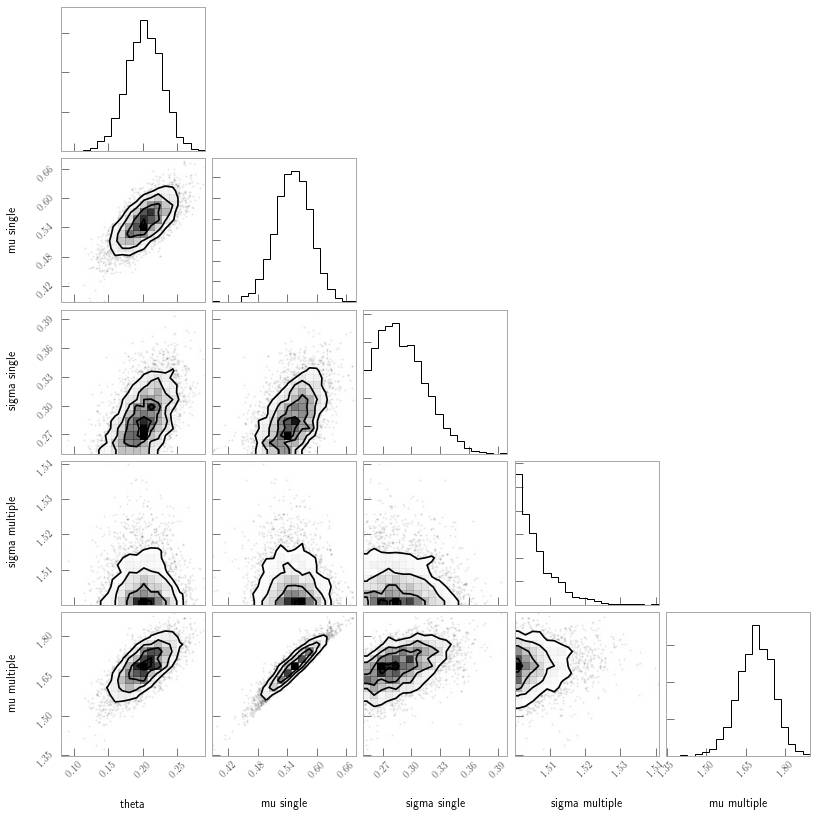

In [31]:

import corner
print(label_names)
print(C.shape)
fig = corner.corner(C.T, labels=label_names)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cbc0367cb2d22a71d58f7777ed03b816 NOW.


OrderedDict([('theta', array(0.18207534)), ('mu_single', array(0.53497278)), ('sigma_single', array(0.25)), ('sigma_multiple', array(1.5)), ('mu_multiple', array(1.62446059))])


/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:362: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(np.asarray(v).dtype, int):
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:364: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


odict_keys(['theta', 'mu_single', 'sigma_single', 'sigma_multiple', 'mu_multiple', 'lp__'])
['theta', 'mu single', 'sigma single', 'sigma multiple', 'mu multiple']
(5, 4000)


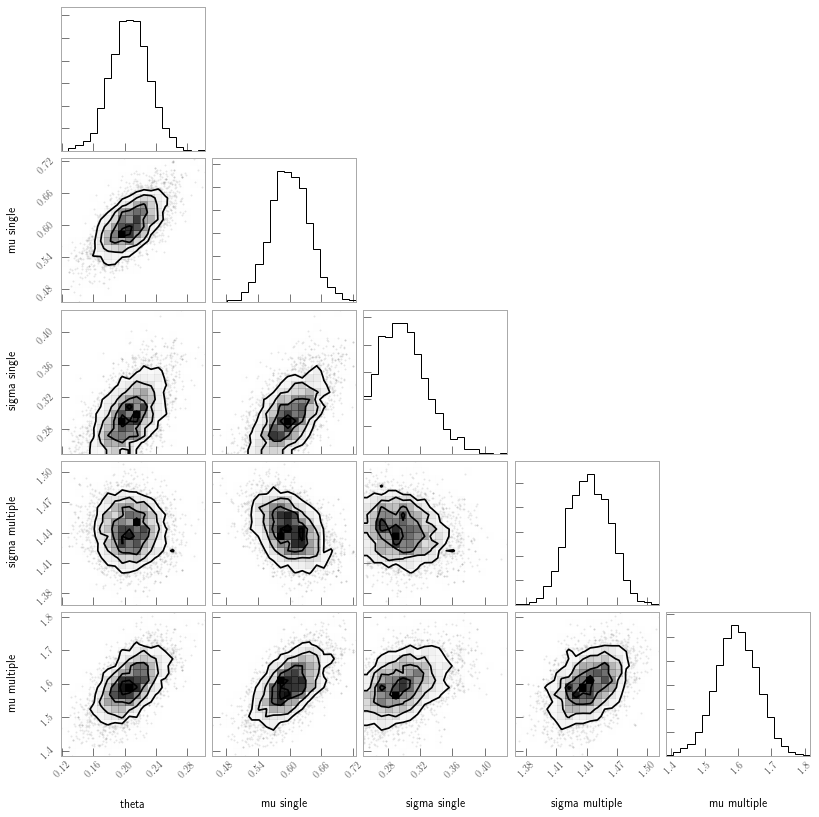

In [32]:
# Fit a two component model to those data.
# TODO: Do this in TensorFlow.

stan_model_code = """
    data {
        int<lower=1> N; // number of data points
        real y[N]; // the data points.
    }

    parameters {
        real<lower=0,upper=1> theta; // the mixing parameter
        real<lower=0,upper=5> mu_single; // single star distribution mean
        real<lower=0.25,upper=2> sigma_single; // single star distribution sigma
        real<lower=0> sigma_multiple; // multiplcity log-normal distribution sigma
        real<lower=log(mu_single)+pow(sigma_multiple,2)> mu_multiple; // multiplicity log-normal distribution mean
    }
    
    model {
        theta ~ beta(5, 5);
        for (n in 1:N)
            target += log_mix(theta,
                              normal_lpdf(y[n] | mu_single, sigma_single),
                              lognormal_lpdf(y[n] | mu_multiple, sigma_multiple));
  }
"""

model_path = "non-parametric-model.stan"
with open(model_path, "w") as fp:
    fp.write(stan_model_code)

import stan_utils as stan
model = stan.load_stan_model(model_path)

N = len(y)
data_dict = dict(y=y, N=N)
init_dict = dict(theta=0.3, mu_single=p_opt.x[1], sigma_single=1,
                 mu_multiple=p_opt.x[3] + 1, sigma_multiple=p_opt.x[4])                                            

print(stan_opt)

samples = model.sampling(**stan.sampling_kwds(data=data_dict, init=init_dict, iter=2000))
chains = samples.extract()

label_names = [ea.replace("_", " ") for ea in tuple(chains.keys())[:-1]]

C = np.array([chains[k] for k in chains.keys() if k != "lp__"])
print(chains.keys())

print(label_names)
print(C.shape)
fig = corner.corner(C.T, labels=label_names)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b888ff10cf236d43bc652a2cf865af5f NOW.


OrderedDict([('theta', array(0.18207534)), ('mu_single', array(0.53497278)), ('sigma_single', array(0.25)), ('sigma_multiple', array(1.5)), ('mu_multiple', array(1.62446059))])


/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:362: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(np.asarray(v).dtype, int):
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:364: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


odict_keys(['theta', 'mu_single', 'sigma_single', 'sigma_multiple', 'mu_multiple', 'lp__'])
['theta', 'mu single', 'sigma single', 'sigma multiple', 'mu multiple']
(5, 4000)


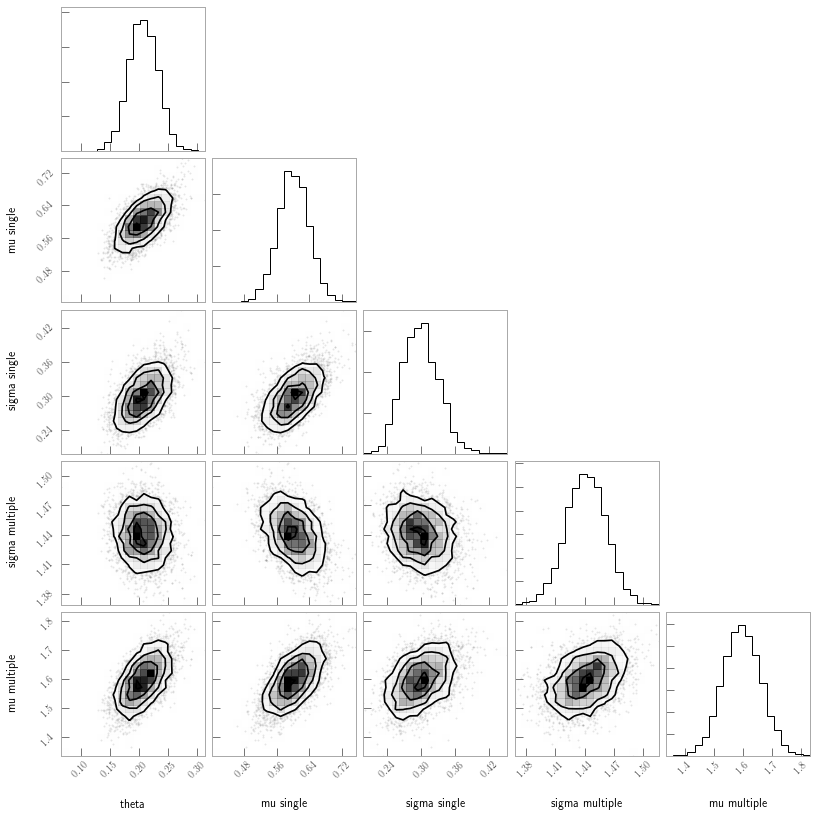

In [33]:
# Fit a two component model to those data.
# TODO: Do this in TensorFlow.

stan_model_code = """
    data {
        int<lower=1> N; // number of data points
        real y[N]; // the data points.
    }

    parameters {
        real<lower=0,upper=1> theta; // the mixing parameter
        real<lower=0> mu_single; // single star distribution mean
        real<lower=0> sigma_single; // single star distribution sigma
        real<lower=0> sigma_multiple; // multiplcity log-normal distribution sigma
        real<lower=log(mu_single)+pow(sigma_multiple,2)> mu_multiple; // multiplicity log-normal distribution mean
    }
    
    model {
        theta ~ beta(5, 5);
        for (n in 1:N)
            target += log_mix(theta,
                              normal_lpdf(y[n] | mu_single, sigma_single),
                              lognormal_lpdf(y[n] | mu_multiple, sigma_multiple));
  }
"""

model_path = "non-parametric-model.stan"
with open(model_path, "w") as fp:
    fp.write(stan_model_code)

import stan_utils as stan
model = stan.load_stan_model(model_path)

N = len(y)
data_dict = dict(y=y, N=N)
init_dict = dict(theta=0.3, mu_single=p_opt.x[1], sigma_single=1,
                 mu_multiple=p_opt.x[3] + 1, sigma_multiple=p_opt.x[4])                                            

print(stan_opt)

samples = model.sampling(**stan.sampling_kwds(data=data_dict, init=init_dict, iter=2000))
chains = samples.extract()

label_names = [ea.replace("_", " ") for ea in tuple(chains.keys())[:-1]]

C = np.array([chains[k] for k in chains.keys() if k != "lp__"])
print(chains.keys())

print(label_names)
print(C.shape)
fig = corner.corner(C.T, labels=label_names)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_88cba8d200573a7a46f566bc1a9bb992 NOW.


OrderedDict([('theta', array(0.18207534)), ('mu_single', array(0.53497278)), ('sigma_single', array(0.25)), ('sigma_multiple', array(1.5)), ('mu_multiple', array(1.62446059))])
OrderedDict([('theta', array(0.20163447)), ('mu_single', array(0.59773418)), ('sigma_single', array(0.28867546)), ('sigma_multiple', array(1.44749208)), ('mu_multiple', array(1.58062449))])


/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:362: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(np.asarray(v).dtype, int):
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:364: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


odict_keys(['theta', 'mu_single', 'sigma_single', 'sigma_multiple', 'mu_multiple', 'lp__'])
['theta', 'mu_single', 'sigma_single', 'sigma_multiple', 'mu_multiple']
(5, 2000)


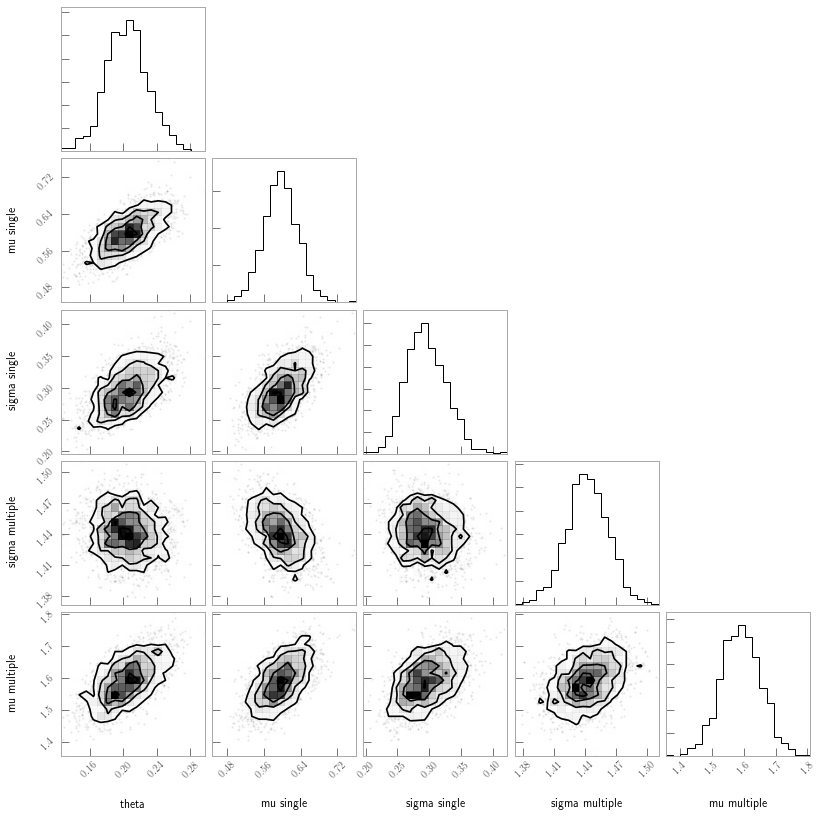

In [70]:
# Fit a two component model to those data.
# TODO: Do this in TensorFlow.

stan_model_code = """
    data {
        int<lower=1> N; // number of data points
        real y[N]; // the data points.
    }

    parameters {
        real<lower=0,upper=1> theta; // the mixing parameter
        real<lower=0> mu_single; // single star distribution mean
        real<lower=0> sigma_single; // single star distribution sigma
        real<lower=0> sigma_multiple; // multiplcity log-normal distribution sigma
        real<lower=log(mu_single)+pow(sigma_multiple,2)> mu_multiple; // multiplicity log-normal distribution mean
    }
    
    model {
        theta ~ beta(5, 5);
        mu_single ~ normal(0, 1);
        sigma_single ~ normal(0, 1);
        
        for (n in 1:N)
            target += log_mix(theta,
                              normal_lpdf(y[n] | mu_single, sigma_single),
                              lognormal_lpdf(y[n] | mu_multiple, sigma_multiple));
  }
"""
#http://localhost:8888/notebooks/notebooks/non-parametric%20model.ipynb#

model_path = "non-parametric-model.stan"
with open(model_path, "w") as fp:
    fp.write(stan_model_code)

import stan_utils as stan
model = stan.load_stan_model(model_path)

N = len(y)
data_dict = dict(y=y, N=N)
# Try optimisation and sampling from a random position.

stan_opt2 = model.optimizing(data=data_dict)

print(stan_opt)
print(stan_opt2)

samples = model.sampling(**stan.sampling_kwds(
    data=data_dict, init=stan_opt2, chains=2, iter=2000))
chains = samples.extract()

label_names = [ea for ea in chains.keys() if ea != "lp__"]


C = np.array([chains[k] for k in label_names])
print(chains.keys())

print(label_names)
print(C.shape)
fig = corner.corner(C.T, labels=[ea.replace("_", " ") for ea in label_names])


/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


1000


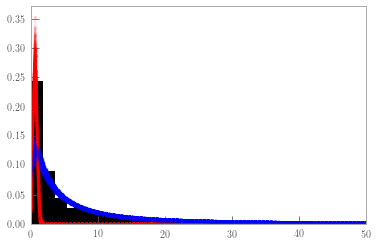

In [71]:
# Make plots of the pdf of each distribution.

def norm_pdf(x, norm_mu, norm_sigma, theta):
    return theta * (2 * np.pi * norm_sigma**2)**(-0.5) * np.exp(-(x - norm_mu)**2/(2*norm_sigma**2))
    
def lognorm_pdf(x, lognorm_mu, lognorm_sigma, theta):
    return (1.0 - theta)/(x * lognorm_sigma * np.sqrt(2*np.pi)) \
           * np.exp(-0.5 * ((np.log(x) - lognorm_mu)/lognorm_sigma)**2)

xi = np.linspace(0, 200, 1000)

indices = np.random.choice(len(C.T), 100, replace=False)
    
fig, ax = plt.subplots()
for index in indices:
    
    idx_theta = label_names.index("theta")
    idx_norm_mu = label_names.index("mu_single")
    idx_norm_sigma = label_names.index("sigma_single")
    idx_lognorm_mu = label_names.index("mu_multiple")
    idx_lognorm_sigma = label_names.index("sigma_multiple")
    
    theta = C.T[index, idx_theta]
    norm_mu = C.T[index, idx_norm_mu]
    norm_sigma = C.T[index, idx_norm_sigma]
    lognorm_mu = C.T[index, idx_lognorm_mu]
    lognorm_sigma = C.T[index, idx_lognorm_sigma]
    
    ax.plot(xi, norm_pdf(xi, norm_mu, norm_sigma, theta), c='r', alpha=0.1)
    ax.plot(xi, lognorm_pdf(xi, lognorm_mu, lognorm_sigma, theta), c='b', alpha=0.1)
    
ax.set_xlim(0, 50)
_ = ax.hist(y, bins=500, facecolor="#000000", zorder=-1, normed=True)
print(y.size)

In [ ]:
stan_model_code = """
    data {
        int<lower=1> N; // number of data points
        int<lower=1> D; // the number of dimensions
        real y[N, D]; // the data
    }

    parameters {
        real<lower=0,upper=1> theta; // the mixing parameter
        real<lower=0> mu_single[D]; // single star distribution mean
        real<lower=0> sigma_single[D]; // single star distribution sigma
        real<lower=0> sigma_multiple[D]; // multiplcity log-normal distribution sigma
        real<lower=log(mu_single)+pow(sigma_multiple,2)> mu_multiple[D]; // multiplicity log-normal distribution mean
    }
    
    model {
        theta ~ beta(5, 5);
        for (d in 1:D)
            for (n in 1:N)
                target += log_mix(theta,
                                  normal_lpdf(y[n, d] | mu_single[d], sigma_single[d]),
                                  lognormal_lpdf(y[n, d] | mu_multiple[d], sigma_multiple[d]));
  }
"""

with open("npm.stan", "w") as fp:
    fp.write(stan_model_code)

    
    

In [ ]:
np.random.choice